<h1>Converting PyTorch model to ONNX</h1>
<p>Specify file path to the PyTorch style transfer model that needs to be converted. After the conversion, the converted ONNX model and the sample test data will be saved in a folder in the same file path as the initial Pytorch model. The conversion may take some time to process. You should see log messages after conversion is done. Here, I converted a PyTorch pointilism model that I trained in PyTorch to ONNX. </p>

In [2]:
import torch
import re
import os
import onnxruntime as rt
from transformer_net import TransformerNet
from onnx_helper import Save

# convert Pytorch model to ONNX
dummy_input = torch.randn(10, 3, 224, 224)
with torch.no_grad():
    model = TransformerNet()
    model_dict = torch.load("PATH TO MODEL")
    for k in list(model_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del model_dict[k]
    model.load_state_dict(model_dict)
    dummy_output = model(dummy_input)
Save("PATH TO MODEL", "transformed_model", model, (dummy_input,), (dummy_output,))
session = rt.InferenceSession("PATH TO MODEL", "\\test_transformed_model\\model.onnx")

graph(%input1 : Float(10, 3, 224, 224),
      %conv1.conv2d.weight : Float(32, 3, 9, 9),
      %conv1.conv2d.bias : Float(32),
      %in1.weight : Float(32),
      %in1.bias : Float(32),
      %conv2.conv2d.weight : Float(64, 32, 3, 3),
      %conv2.conv2d.bias : Float(64),
      %in2.weight : Float(64),
      %in2.bias : Float(64),
      %conv3.conv2d.weight : Float(128, 64, 3, 3),
      %conv3.conv2d.bias : Float(128),
      %in3.weight : Float(128),
      %in3.bias : Float(128),
      %res1.conv1.conv2d.weight : Float(128, 128, 3, 3),
      %res1.conv1.conv2d.bias : Float(128),
      %res1.in1.weight : Float(128),
      %res1.in1.bias : Float(128),
      %res1.conv2.conv2d.weight : Float(128, 128, 3, 3),
      %res1.conv2.conv2d.bias : Float(128),
      %res1.in2.weight : Float(128),
      %res1.in2.bias : Float(128),
      %res2.conv1.conv2d.weight : Float(128, 128, 3, 3),
      %res2.conv1.conv2d.bias : Float(128),
      %res2.in1.weight : Float(128),
      %res2.in1.bias : Float(

<h1>Loading style image and preprocessing</h1>
<p>Specify path for input image. Increase the scale when running into memory issues. </p>

In [4]:
from PIL import Image
import numpy as np

# loading input and resize if needed
image = Image.open("PATH TO IMAGE")
scale = 1 # increase the scale when running into memory issues
image = image.resize((int(image.size[0] / scale), int(image.size[1] / scale)), Image.ANTIALIAS)

# Preprocess image
x = np.array(image).astype('float32')
x = np.transpose(x, [2, 0, 1])
x = np.expand_dims(x, axis=0)

<h1>Running the model in ORT and postprocessing</h1>
<p>After running this block, the output image will show up.</p>

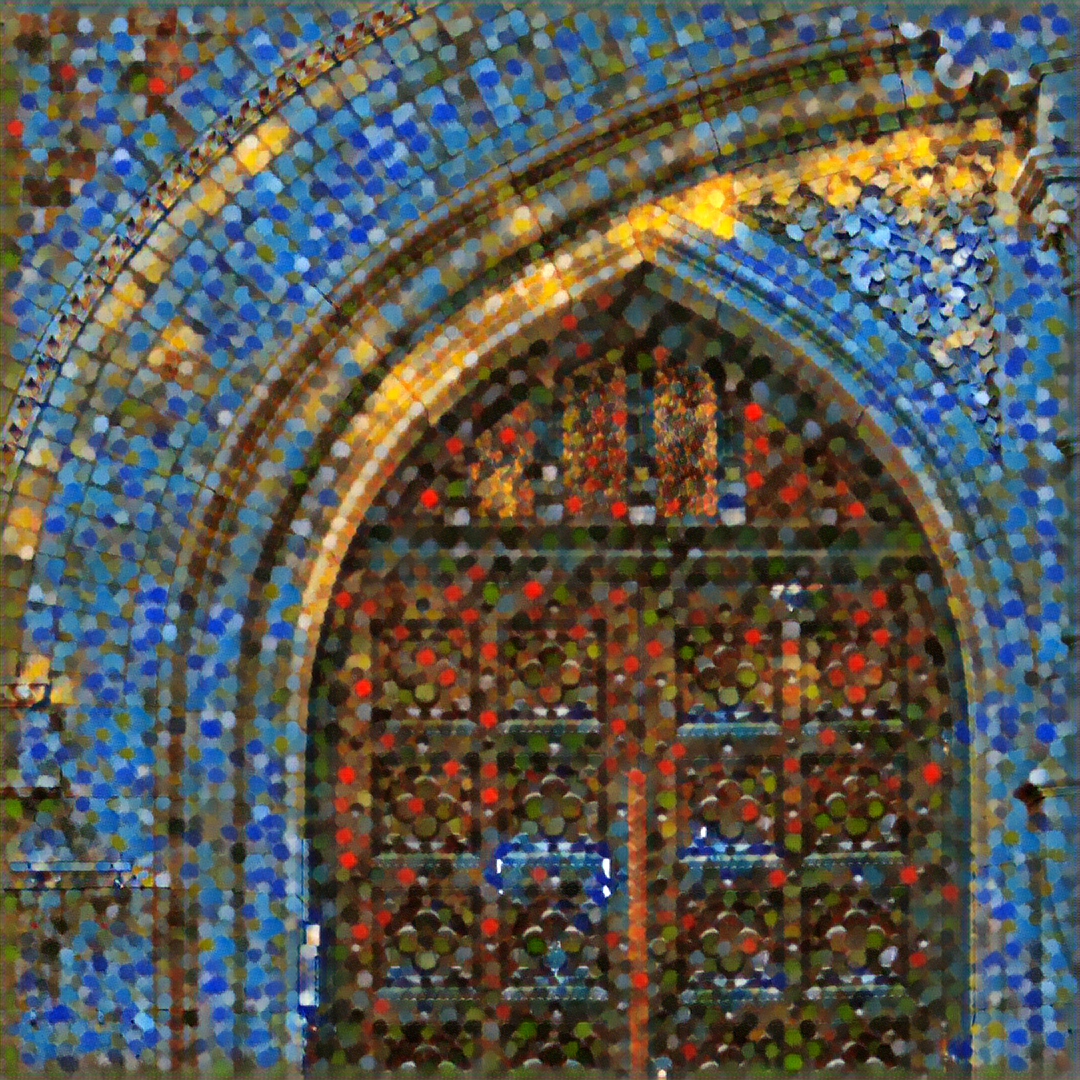

In [5]:
output_name = session.get_outputs()[0].name
input_name = session.get_inputs()[0].name
result = session.run([output_name], {input_name: x})[0][0] 

# postprocess
result = np.clip(result, 0, 255)
result = result.transpose(1,2,0).astype("uint8")
img = Image.fromarray(result)
img